# **Improved Model**

## Data Preparation

### Import Modified Feature Matrix

A modification has been made to the feature matrix extracted in "Data Preparation" module. The changes include:

(1) Corrected a mistake in function that calculates the ignition temperature. 
(2) Baseline correction now only incorporate flattening and smoothing the curve, the minor peaks are no longer removed. This change is trying to keep the baseline correction result as close as the commercialized software.

The feature new matrix is stored in a .csv file, which contains features extracted from raw data based on physical meanings, as well as the labels indicating whether the material passes FR tests or not. A total of 41 observations and 5 features were included. Specifically, the output consists of 3 labels, where 0=fail, 1=pass, 2=hard to determine.

We start by importing the .csv file. Appropriate libraries are imported.

In [1]:
# Read in the data
import numpy as np
import pandas as pd
import pylab as plt
data = pd.read_csv("feature_matrix.csv")
data.head()

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels
0,24722.818517,482.246,350.805,25955.104346,134.021649,2
1,14879.480392,537.858,438.643,15591.943456,120.959219,2
2,16584.116501,515.457,366.537,17369.365738,77.548988,1
3,20246.452607,482.774,396.996,21344.250614,191.805110,0
4,26622.142067,472.215,388.929,28036.752193,260.118532,0


### Scale Data

Based on simple observation on the raw features, it is not suprised to see there are magnitude difference among all features. To eliminate the weight bias caused by descrepancy with units, standard scaling is applied and all analysis will be performed on top of the scaled dataset.

In [2]:
# import standard scaler
from sklearn.preprocessing import StandardScaler

# scale the data (excluding labels)
scaler = StandardScaler()
scaled = scaler.fit_transform(data.drop(columns='FR_labels'))
scaled = pd.DataFrame(scaled)
scaled['FR_labels'] = data.loc[:,'FR_labels']    # add FR_labels to new dataframe
scaled.columns = data.columns    # add column headers back to new dataframe
scaled.head()

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels
0,1.808411,-0.424203,-0.990329,1.778631,-0.202424,2
1,-0.335103,0.879587,0.744864,-0.365567,-0.258909,2
2,0.036103,0.354409,-0.679551,0.002192,-0.446622,1
3,0.833624,-0.411824,-0.077850,0.824619,0.047441,0
4,2.222013,-0.659374,-0.237209,2.209336,0.342840,0


###Baseline Model Pipeline Diagram

<img src="images/PipelineDiagram.png" alt="Pipeline Diagram"
height="600">

## SVC Baseline Model

According to the pipeline diagram in our description file, a 90% train-test split will be performed to the scaled dataset. Support Vector Classifier (SVC) is selected as our baseline model. GridSearchCV is used for determining the optimal hyperparameters ($C$ and $\gamma$) with a 3-fold cross-validation. At the end, the accuracy, precision and recall scores are printed as benchmark metrics with other potential models.

Our Support Vector Classifier (SVC) baseline model will not consider previously discussed issues of multicollinearity and outliers with the data but will establish the baseline performance for a classification model. Because dropping the outlier at index=2 made a significant difference, we will be dropping that data point for the baseline but further exploring its significance in the future.

In [3]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# final outlier
origin_feature=scaled

# perform a train-test split. 90% of original data will be used for training
X_svc = origin_feature.drop(columns='FR_labels').values
y_svc = origin_feature['FR_labels'].values
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size = 0.10)

# define support vector model with rbf kernel
svc = SVC(kernel = 'rbf')

# build up parameter grid and perform GridSearchCV to find the best estimator
alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas
sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

param_grid_svc = {'C': Cs,'gamma': gammas}

svc_search = GridSearchCV(svc, param_grid_svc, cv = 3)
svc_search.fit(X_train_svc,y_train_svc)

# resulting predictions
predict_svc = svc_search.best_estimator_.predict(X_test_svc)
full_predict_svc = svc_search.best_estimator_.predict(X_svc)

# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_svc, predict_svc)))
print('Precision for validation set: {}'.format(precision_score(y_test_svc, predict_svc, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_svc, predict_svc, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_svc, full_predict_svc)))
print('Precision for full dataset: {}'.format(precision_score(y_svc, full_predict_svc, average='macro')))
print('Recall for full dataset: {}'.format(recall_score(y_svc, full_predict_svc, average='macro')))

Accuracy for validation set: 0.4
Precision for validation set: 0.625
Recall for validation set: 0.625

Accuracy for full dataset: 0.6585365853658537
Precision for full dataset: 0.4380952380952381
Recall for full dataset: 0.47222222222222215


C:\Users\cjher\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Baseline Model Discussion:**  
After running the above cell a few times, we notice that the score changes drastically based on the random set of X_train, y_train chosen. This is caused by our small data set and should be addressed in future models by generating or obtaining additional data. Additionally, due to the same problem, sometimes the model is unable to predict the borderline class (label 2) shown in the warning above, which is composed of materials that do not have a fixed flame retardant test result (sometimes pass and sometimes fail).

With regards to scores of the validation set and the full dataset, it seems that the data is not overfitting much and seems to generalize well when applied to the larger data set.

#**Improved Models**

In [4]:
# Read in the data
import numpy as np
import pandas as pd
import pylab as plt
data = pd.read_csv("feature_matrix.csv")
y_label=data['FR_labels'].values
data.head()

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels
0,24722.818517,482.246,350.805,25955.104346,134.021649,2
1,14879.480392,537.858,438.643,15591.943456,120.959219,2
2,16584.116501,515.457,366.537,17369.365738,77.548988,1
3,20246.452607,482.774,396.996,21344.250614,191.805110,0
4,26622.142067,472.215,388.929,28036.752193,260.118532,0


##PCA (Principal Component Analysis)

Principal Component Analysis (PCA) will be performed on the original MCC dataset, which includes raw data and curve-flattened data. 10 most important PCs will be extracted from each dataset and return a (41*10) feature matrix. This matrix, itself, will be used as the input for the prediction model. In addition, the PCA extracted matrix will be combined with the original feature matrix for prediction.

In [5]:
# run if rampy is not installed
%pip install rampy

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\cjher\anaconda3\lib\site-packages (from rampy) (1.0.5)



In [6]:
#
# params: x, array of temperature values; y, array of HRR values
# returns: y_corrected_filtered, flattened and smoothed arrays; 
# https://github.com/charlesll/rampy
# https://github.com/charlesll/rampy/blob/master/examples/baseline_fit.ipynb

import rampy as rp
from scipy.signal import savgol_filter

def baseflatten(x,y):
    bir = np.array([[0,800]])
    y_corrected, background = rp.baseline(x,y,bir,"arPLS",lam=10**10) #flatten the curve
    y_corrected_filtered=savgol_filter(y_corrected.flatten(),15,3) #smooth the gradient curve
    return y_corrected_filtered

Principal Component Analysis (PCA) will be performed on the original MCC dataset, which includes raw data and curve-flattened data. 5 most important PCs will be extracted from each dataset and return a (41*10) feature matrix. This matrix, itself, will be used as the input for the prediction model. In addition, the PCA extracted matrix will combine with the feature matrix extracted based on physical meanings.

In [7]:
# Read in the raw data
df = pd.read_csv("./MCC_raw.csv")
data_raw = df.drop([0]).astype(float)
data_raw[data_raw.columns[::3]].head(5)

,Adhesive-1-1,Adhesive-2-1,Adhesive-3-1,Adhesive-4-1,Adhesive-5-1,Adhesive-6-1,Adhesive-7-1,Adhesive-8-1,Adhesive-9-1,Adhesive-10-1,...,Fiber-FR-10,Fiber-FR-11,Fiber-FR-12,Fiber-FR-13,Fiber-FR-14,Fiber-FR-15,Fiber-FR-16,Fiber-17,Fiber-18,Fiber-19
1,73.744,74.630,74.621,74.539,74.815,75.161,75.574,74.589,75.411,75.404,...,74.736,75.393,74.683,73.755,74.602,74.629,75.068,73.866,74.566,73.599
2,73.711,74.653,74.683,74.552,74.815,75.181,75.580,74.628,75.390,75.352,...,74.719,75.416,74.691,73.679,74.588,74.670,75.021,73.889,74.599,73.637
3,73.749,74.659,74.715,74.519,74.893,75.207,75.582,74.650,75.376,75.345,...,74.678,75.360,74.725,73.665,74.604,74.699,74.989,73.901,74.622,73.658
4,73.741,74.688,74.724,74.498,74.904,75.236,75.617,74.704,75.397,75.335,...,74.652,75.418,74.756,73.647,74.628,74.735,74.962,73.928,74.609,73.653
5,73.780,74.745,74.745,74.478,74.951,75.237,75.603,74.720,75.365,75.320,...,74.669,75.412,74.765,73.607,74.704,74.778,74.959,73.933,74.644,73.733


In [8]:
# Drop all non-numerical (NaN) values
def is_positive_numeric(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    elif pd.isnull(x):
        return False
    else:
        return True
    
numeric_map = data_raw.applymap(is_positive_numeric)
data=data_raw[numeric_map.all(axis=1).values]
data.tail(5)

,Adhesive-1-1,Unnamed: 1,Unnamed: 2,Adhesive-2-1,Unnamed: 4,Unnamed: 5,Adhesive-3-1,Unnamed: 7,Unnamed: 8,Adhesive-4-1,...,Unnamed: 113,Fiber-17,Unnamed: 115,Unnamed: 116,Fiber-18,Unnamed: 118,Unnamed: 119,Fiber-19,Unnamed: 121,Unnamed: 122
1395,737.295,-0.002,1.016,739.624,-5.602,1.014,739.985,-6.388,1.034,735.241,...,0.998,737.426,-0.924,1.025,738.191,1.522,1.009,737.991,3.252,1.013
1396,737.805,0.102,1.022,740.144,-5.294,1.021,740.486,-6.147,1.003,735.757,...,1.017,737.927,-0.815,1.019,738.698,1.733,1.001,738.499,3.296,1.025
1397,738.282,0.155,0.987,740.684,-5.458,1.061,741.009,-6.113,1.025,736.241,...,1.040,738.441,-0.762,1.015,739.192,1.684,1.001,739.003,3.080,1.014
1398,738.803,0.020,0.996,741.150,-5.387,1.007,741.526,-6.189,1.040,736.738,...,1.004,738.957,-0.871,1.030,739.718,1.605,1.019,739.498,3.180,0.998
1399,739.309,0.060,1.028,741.652,-5.352,0.969,742.025,-6.322,1.015,737.225,...,1.004,739.427,-0.804,0.985,740.200,1.433,1.007,740.014,3.073,1.010


In the following cell, two 2-D arrays storing the x values (temperature) and y values (HRR) are created. 

1) xy_raw: x & y values for raw data

2) xy_flattened: x & y values for curve flattened data

In [9]:
import warnings
warnings.filterwarnings("ignore") 
xy_raw=[]
xy_flattened=[]
xy_corrected=[]
for i in range(0, data.shape[1], 3):
    # extract values for x and y and HR
    select = data.iloc[:,i:i+3]
    x = select.iloc[:,0].values
    xy_raw.append(x)
    xy_flattened.append(x)
    
    y = select.iloc[:,1].values
    xy_raw.append(y)
    
    y_b= baseflatten(x,y) #flatten the curve
    xy_flattened.append(y_b.flatten())

    # Uncomment the codes to check the baseline corrected curves

    #fig, ax=plt.subplots()
    #ax.plot(x,y,label='original data')
    #ax.plot(x,y_b,label='flattened data')
    #ax.legend()

xy_raw=np.array(xy_raw)
xy_flattened=np.array(xy_flattened)

y values (HRR values) will be used for PCA, the following cells will extract two matrices with 41 rows (observations) and 1399 columns (y values as features). 

In [10]:
features_raw=xy_raw[1::2,:]
print(features_raw.shape)
features_flattened=xy_flattened[1::2,:]
print(features_flattened.shape)

(41, 1399)
(41, 1399)


Because the x values deviate slightly among each observation, it might lead to error if we use original y values directly. Therefore, for each observation, a linear interpolation will be performed and all y values will be re-calculated based on the same x values. Aligned feature matrices and heatmap for correlation matrices are printed below 

In [11]:
from scipy import interpolate
# define new aligned x values
x_aligned=np.linspace(max(xy_raw[::2,1]),min(xy_raw[::2,-1]),num=1400)

# function interpolating each observations, and return a new feature matrix with aligned x values
def align_data(xy_inp):
    features_inp_aligned=[]
    for i in range(0,41):
        x = xy_inp[2*i,:]
        y=xy_inp[2*i+1,:]
        
        # interpolate the curve
        interp = interpolate.interp1d(x, y)
        y_aligned=interp(x_aligned)
        features_inp_aligned.append(y_aligned)

        # Uncomment the codes to check the interpolation results
        
        #fig, ax=plt.subplots()
        #ax.plot(x,y,label='original data')
        #ax.plot(x_aligned,y_aligned,label='interpolated data')
        #ax.legend()
    features_inp_aligned=np.array(features_inp_aligned)
    return features_inp_aligned

In [12]:
# Calculate feature matrices with aligned data
features_raw_aligned=align_data(xy_raw)
features_flattened_aligned=align_data(xy_flattened)
print(features_raw_aligned.shape)
print(features_flattened_aligned.shape)

(41, 1400)
(41, 1400)


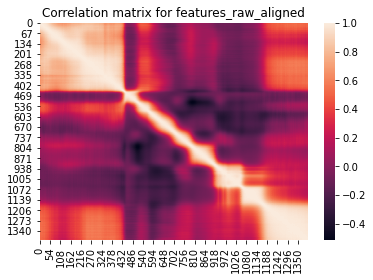

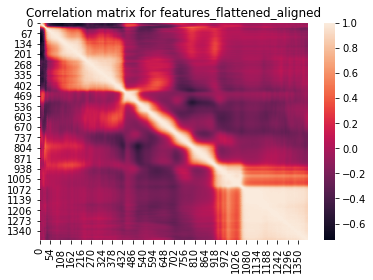

In [13]:
import seaborn as sns
corr_raw_aligned=np.corrcoef(features_raw_aligned.T)
hm1=sns.heatmap(corr_raw_aligned).set_title('Correlation matrix for features_raw_aligned')

plt.figure()
corr_flattened_aligned=np.corrcoef(features_flattened_aligned.T)
hm2=sns.heatmap(corr_flattened_aligned).set_title('Correlation matrix for features_flattened_aligned')

Find the first 10 PCs based on aligned features

In [14]:
from sklearn.decomposition import PCA
k=10
pca_raw=PCA(n_components=k)
pca_flattened=PCA(n_components=k)
pca_corrected=PCA(n_components=k)

raw_pc=pca_raw.fit_transform(features_raw_aligned)
print(raw_pc[0,:])

flattened_pc=pca_flattened.fit_transform(features_flattened_aligned)
print(flattened_pc[0,:])

[-686.42103209  311.84630269  710.71679886 -241.66235881  837.55141237
  -73.54494024   35.39005441  -50.01410212  132.44691814 -177.28925658]
[-675.35973346  297.70606542  709.67295662 -210.1040181   880.6852894
   14.376059     74.34795734   49.63853734  170.4150219  -148.95422749]


Text(0.5, 1.0, 'Explained Variance for flattened data')

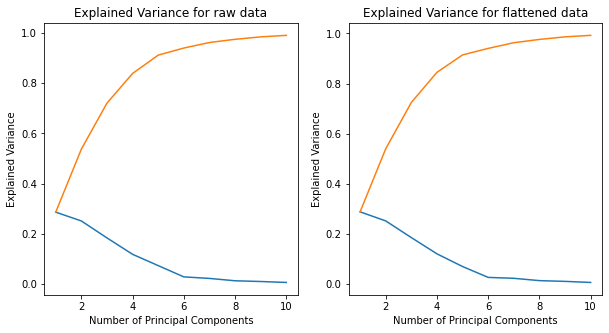

In [15]:
raw_mean=raw_pc.mean(axis=0)
flattened_mean=flattened_pc.mean(axis=0)

fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1,len(raw_mean)+1),pca_raw.explained_variance_ratio_)
axes[0].plot(range(1,len(raw_mean)+1),np.cumsum(pca_raw.explained_variance_ratio_))
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Explained Variance')
axes[0].set_title('Explained Variance for raw data')

axes[1].plot(range(1,len(flattened_mean)+1),pca_flattened.explained_variance_ratio_)
axes[1].plot(range(1,len(flattened_mean)+1),np.cumsum(pca_flattened.explained_variance_ratio_))
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Explained Variance')
axes[1].set_title('Explained Variance for flattened data')

Text(0.5, 1.0, 'Reconstructed PCs for flattened data')

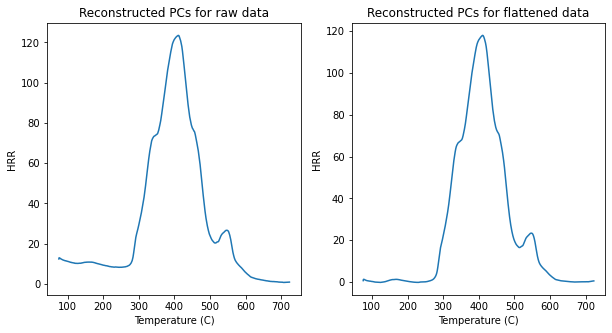

In [16]:
raw_reconstructed=pca_raw.inverse_transform(raw_mean)
flattened_reconstructed=pca_flattened.inverse_transform(flattened_mean)

fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(x_aligned,raw_reconstructed)
axes[0].set_xlabel('Temperature (C)')
axes[0].set_ylabel('HRR')
axes[0].set_title('Reconstructed PCs for raw data')

axes[1].plot(x_aligned,flattened_reconstructed)
axes[1].set_xlabel('Temperature (C)')
axes[1].set_ylabel('HRR')
axes[1].set_title('Reconstructed PCs for flattened data')

### Forward selection to determine most predictive PCs???

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def baseline_predict(X_svc,y_svc):
    # perform a train-test split. 90% of original data will be used for training
    X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size = 0.10)

    # define support vector model with rbf kernel
    svc = SVC(kernel = 'rbf')

    # build up parameter grid and perform GridSearchCV to find the best estimator
    alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
    Cs = 1 / alphas
    sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
    gammas = 1. / 2 / sigmas**2

    param_grid_svc = {'C': Cs,'gamma': gammas}

    svc_search = GridSearchCV(svc, param_grid_svc, cv = 3)
    svc_search.fit(X_train_svc,y_train_svc)

    # resulting predictions
    predict_svc = svc_search.best_estimator_.predict(X_test_svc)
    full_predict_svc = svc_search.best_estimator_.predict(X_svc)
    
    test_accuracy=accuracy_score(y_test_svc, predict_svc)
    test_precision=precision_score(y_test_svc, predict_svc, average='macro')
    test_recall=recall_score(y_test_svc, predict_svc, average='macro')
    
    full_accuracy=accuracy_score(y_svc, full_predict_svc)
    full_precision=precision_score(y_svc, full_predict_svc, average='macro')
    full_recall=recall_score(y_svc, full_predict_svc, average='macro')
    
    return test_accuracy,test_precision,test_recall,full_accuracy,full_precision,full_recall


## Generative Model

Due to the small size of our dataset, it is n

In [18]:
feature_matrix = pd.read_csv("feature_matrix.csv")
feature_matrix['PC1'] = flattened_pc[:,0]
feature_matrix['PC2'] = flattened_pc[:,1]
feature_matrix['PC3'] = flattened_pc[:,2]
feature_matrix.head(10)

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels,PC1,PC2,PC3
0,24722.818517,482.246,350.805,25955.104346,134.021649,2,-675.359733,297.706065,709.672957
1,14879.480392,537.858,438.643,15591.943456,120.959219,2,909.690756,342.229152,38.531590
2,16584.116501,515.457,366.537,17369.365738,77.548988,1,63.184583,-388.364571,435.757401
3,20246.452607,482.774,396.996,21344.250614,191.805110,0,785.952883,1344.401661,280.523465
4,26622.142067,472.215,388.929,28036.752193,260.118532,0,-1375.196882,1562.118158,335.994645
5,12581.675639,488.529,292.177,13257.707466,36.933912,1,312.467042,-994.660995,-171.510404
6,27364.231613,468.963,377.870,28900.669510,238.762552,0,-1823.270549,1123.422047,811.066965
7,14539.335519,469.506,384.928,15291.533325,139.195486,1,-673.781301,-70.424838,63.789101
8,15665.463662,437.267,334.539,16466.951534,114.496239,1,-534.780041,-1735.166316,67.101112
9,13535.355054,461.318,343.769,14282.096095,84.124726,1,-613.962631,-1013.199055,282.618485


In [19]:
data = feature_matrix
# import standard scaler
from sklearn.preprocessing import StandardScaler

# scale the data (excluding labels)
scaler = StandardScaler()
scaled = scaler.fit_transform(data.drop(columns='FR_labels'))
scaled = pd.DataFrame(scaled)
scaled.columns = data.drop(columns='FR_labels').columns
scaled['FR_labels'] = data.loc[:,'FR_labels']    # add FR_labels to new dataframe
scaled.head()
origin_feature_matrix=scaled
origin_feature_matrix.shape


(41, 9)

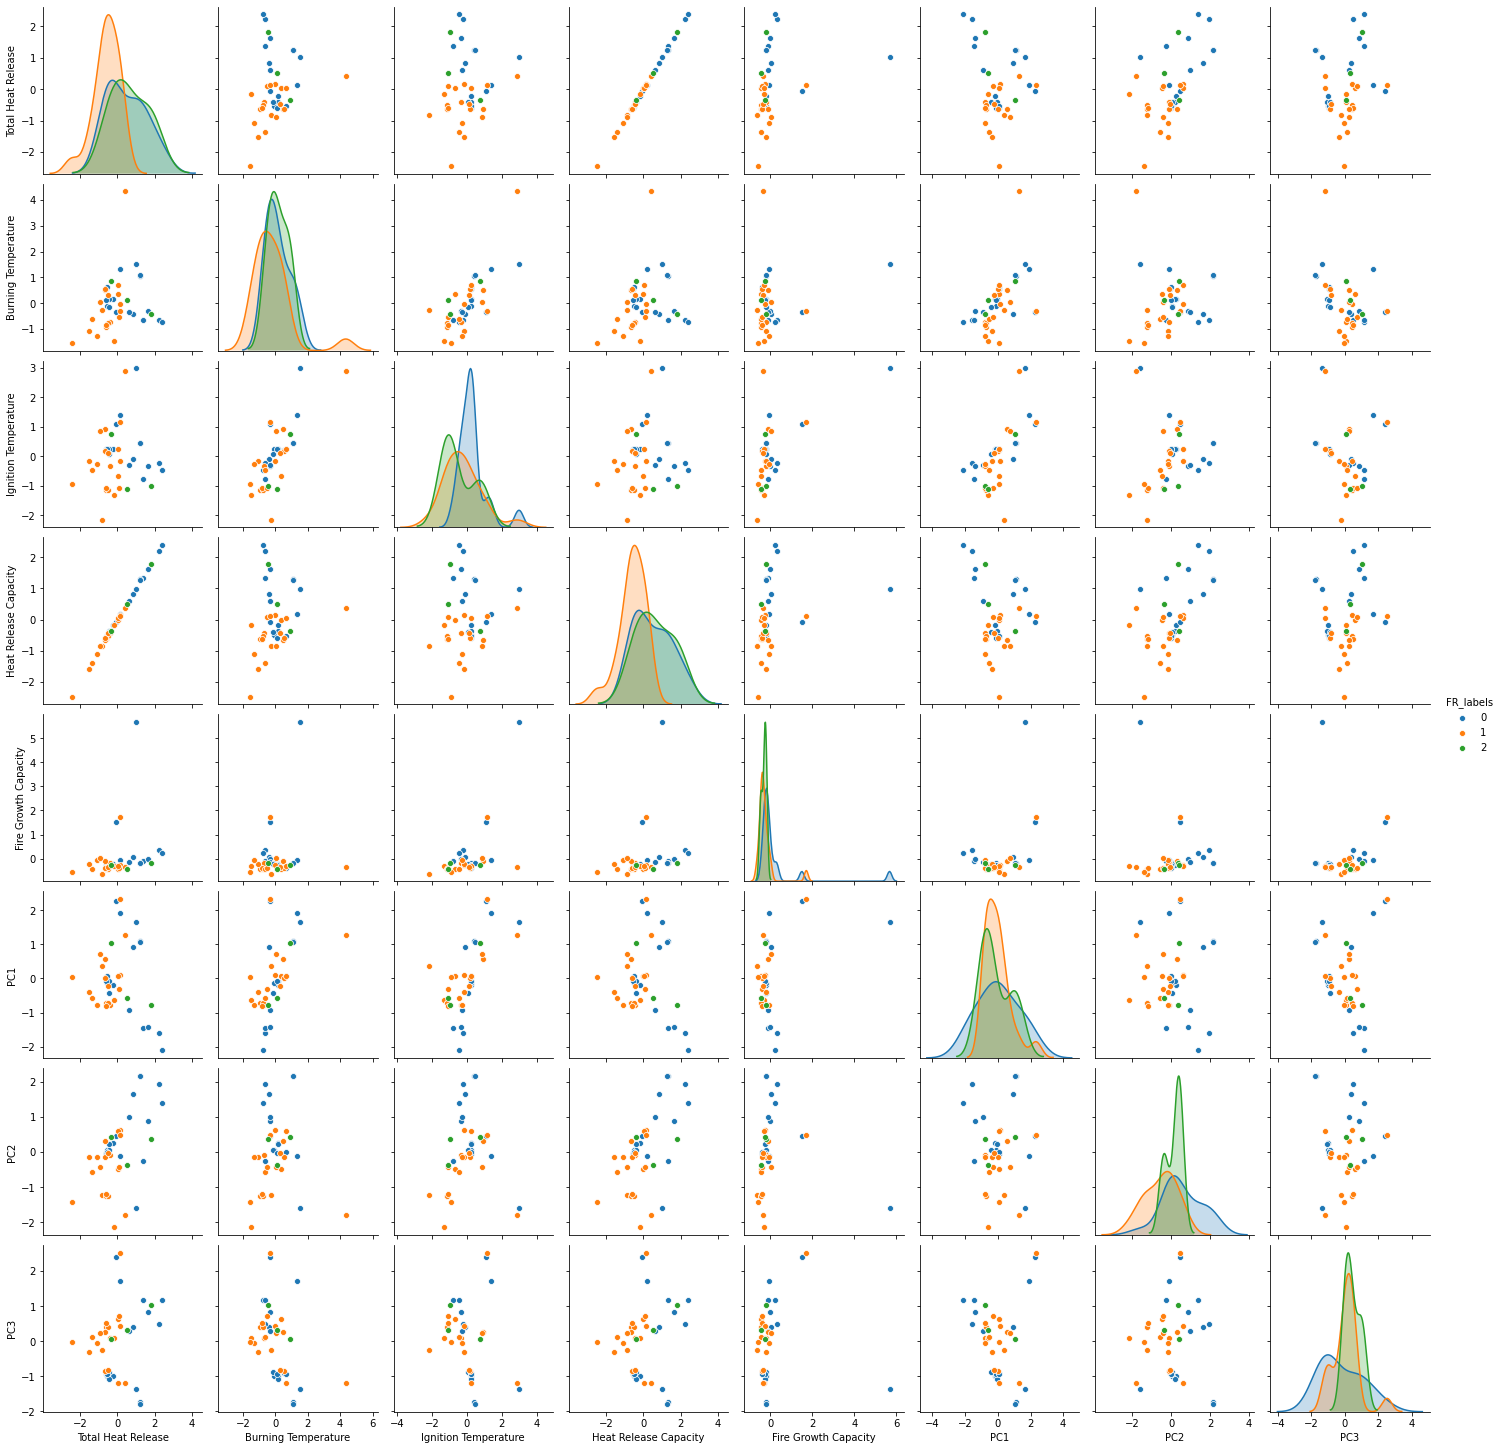

In [20]:
# plot
import seaborn as sns
sns.pairplot(scaled,hue='FR_labels')

###Gaussian Mixture

[5]


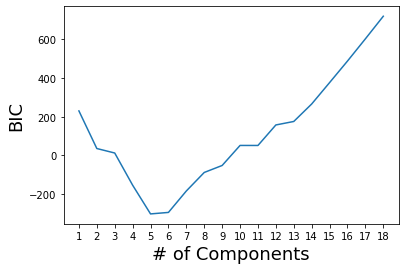

In [21]:
y = scaled['FR_labels']
from sklearn.mixture import GaussianMixture

X = scaled.drop(columns='FR_labels')[y == 0].values
n_components = np.arange(1, 19)

BICs = []
models = []
for n in n_components:
    gmm_n =  GaussianMixture(n, covariance_type = 'full').fit(X)
    bic = gmm_n.bic(X)
    BICs.append(bic)
    models.append(gmm_n)
    
        
fig, ax = plt.subplots()
ax.plot(n_components, BICs)
ax.set_xlabel('# of Components', size = 18);
ax.set_ylabel('BIC', size = 18)
ax.set_xticks(n_components);
best_n=[]
best_n.append(n_components[BICs == min(BICs)][0])
print(best_n)

[5, 6]


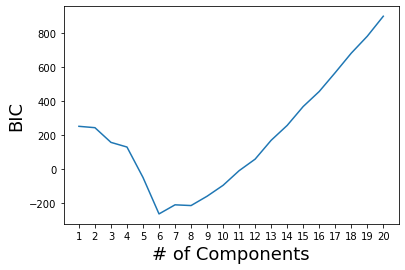

In [22]:
y = scaled['FR_labels']
from sklearn.mixture import GaussianMixture

X = scaled.drop(columns='FR_labels')[y == 1].values
n_components = np.arange(1, 21)

BICs = []
models = []
for n in n_components:
    gmm_n =  GaussianMixture(n, covariance_type = 'full').fit(X)
    bic = gmm_n.bic(X)
    BICs.append(bic)
    models.append(gmm_n)
    
        
fig, ax = plt.subplots()
ax.plot(n_components, BICs)
ax.set_xlabel('# of Components', size = 18);
ax.set_ylabel('BIC', size = 18)
ax.set_xticks(n_components);
best_n.append(n_components[BICs == min(BICs)][0])
print(best_n)

In [23]:
vals = []
for i in range(0,2):
  X = scaled.drop(columns='FR_labels')[y == i].values
  gmm = GaussianMixture(n_components = 5, covariance_type = 'full')
  gmm.fit(X)
  new = gmm.sample(100)
  vals.append(new[0])

In [24]:
new0 = pd.DataFrame(vals[0])
new0['FR_labels'] = np.zeros(100).astype(int)
new0.columns = scaled.columns
new1 = pd.DataFrame(vals[1])
new1['FR_labels'] = np.ones(100).astype(int)
new1.columns = scaled.columns
final = scaled.append(new0)
final = final.append(new1)
final

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,PC1,PC2,PC3,FR_labels
0,1.808411,-0.424203,-0.990329,1.778631,-0.202424,-0.780066,0.367749,1.022207,2
1,-0.335103,0.879587,0.744864,-0.365567,-0.258909,1.050728,0.422747,0.055501,2
2,0.036103,0.354409,-0.679551,0.002192,-0.446622,0.072981,-0.479737,0.627661,1
3,0.833624,-0.411824,-0.077850,0.824619,0.047441,0.907806,1.660705,0.404063,0
4,2.222013,-0.659374,-0.237209,2.209336,0.342840,-1.588405,1.929644,0.483964,0
...,...,...,...,...,...,...,...,...,...
95,-1.081838,0.224518,1.123469,-1.085874,-0.012660,0.706580,-0.133468,0.858272,1
96,-0.510300,0.109623,0.655658,-0.490908,-0.065789,0.236920,0.120113,0.023390,1
97,-0.077270,0.667905,0.413082,-0.069270,-0.264607,0.160714,0.625354,-0.822917,1
98,-0.682197,0.255999,0.562615,-0.656169,-0.160562,0.267802,-0.090997,-0.167082,1


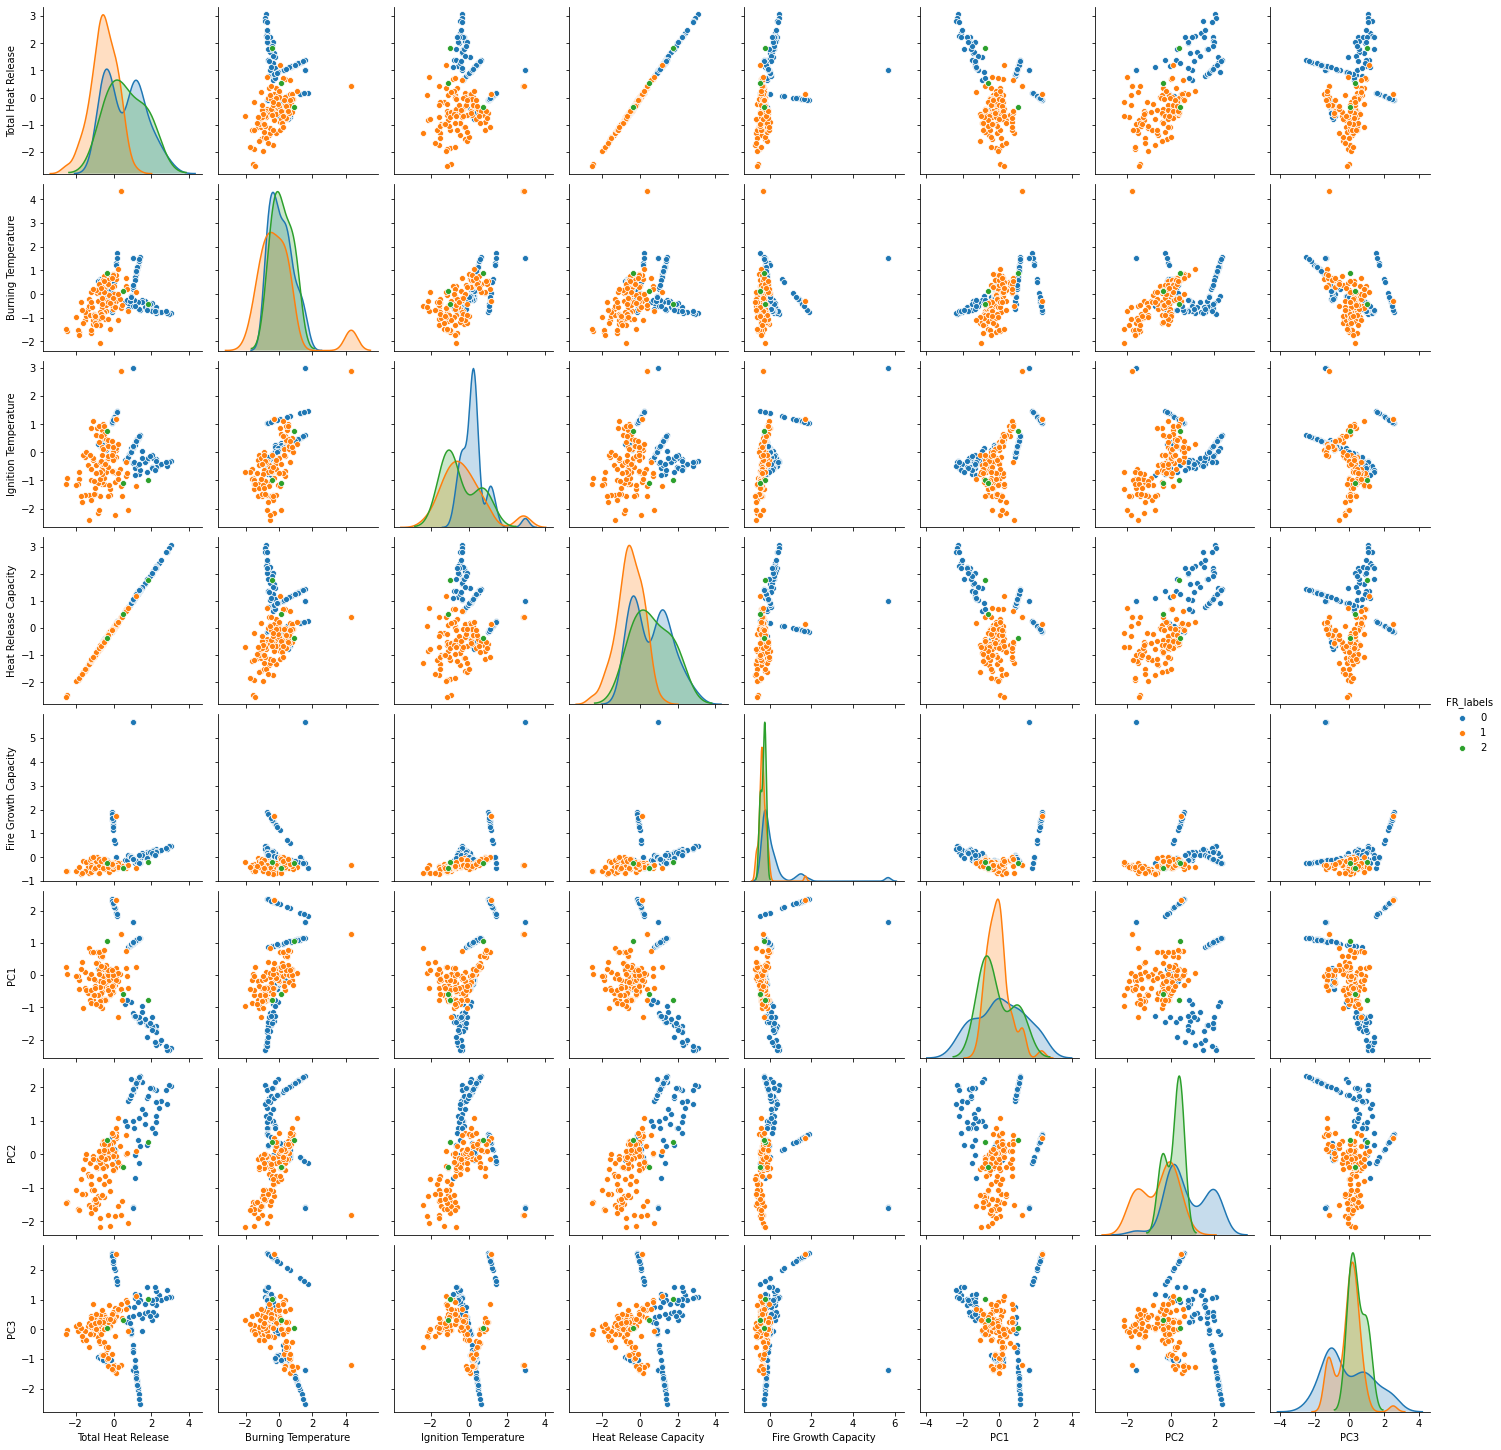

In [25]:
sns.pairplot(final,hue='FR_labels')

This actually doesn't look too bad. It seems to preserve the distribution of the original data, even with the addition of 100 points. I did not add points for FR_label=2 class because it is sparse to begin with.

###Kernel Density Estimation

In [26]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [27]:
vals = []
for i in range(0,2):
  X = scaled.drop(columns='FR_labels')[y == i].values

  # use grid search cross-validation to optimize the bandwidth
  params = {'bandwidth': np.logspace(-1, 1, 20)}
  grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
  grid.fit(X)

  print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
  print(grid.best_estimator_.score(X))

  # use the best estimator to compute the kernel density estimate
  kde = KernelDensity(bandwidth = .54, kernel = 'gaussian')
  kde.fit(X)
  print(np.logspace(-1, 1, 20))
  print(kde.score(X))
  new = kde.sample(100)
  vals.append(new)

best bandwidth: 0.6951927961775606
-117.70908947368294
[ 0.1         0.1274275   0.16237767  0.20691381  0.26366509  0.33598183
  0.42813324  0.54555948  0.6951928   0.88586679  1.12883789  1.43844989
  1.83298071  2.33572147  2.97635144  3.79269019  4.83293024  6.15848211
  7.8475997  10.        ]
-83.34054583333229
best bandwidth: 0.6951927961775606
-136.85204064684024
[ 0.1         0.1274275   0.16237767  0.20691381  0.26366509  0.33598183
  0.42813324  0.54555948  0.6951928   0.88586679  1.12883789  1.43844989
  1.83298071  2.33572147  2.97635144  3.79269019  4.83293024  6.15848211
  7.8475997  10.        ]
-100.98346153566186


In [28]:
new0 = pd.DataFrame(vals[0])
new0['FR_labels'] = np.zeros(100).astype(int)
new0.columns = scaled.columns
new1 = pd.DataFrame(vals[1])
new1['FR_labels'] = np.ones(100).astype(int)
new1.columns = scaled.columns
final = scaled.append(new0)
final = final.append(new1)
final

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,PC1,PC2,PC3,FR_labels
0,1.808411,-0.424203,-0.990329,1.778631,-0.202424,-0.780066,0.367749,1.022207,2
1,-0.335103,0.879587,0.744864,-0.365567,-0.258909,1.050728,0.422747,0.055501,2
2,0.036103,0.354409,-0.679551,0.002192,-0.446622,0.072981,-0.479737,0.627661,1
3,0.833624,-0.411824,-0.077850,0.824619,0.047441,0.907806,1.660705,0.404063,0
4,2.222013,-0.659374,-0.237209,2.209336,0.342840,-1.588405,1.929644,0.483964,0
...,...,...,...,...,...,...,...,...,...
95,-0.662276,0.455443,0.575375,-1.039101,-0.368334,1.675698,-0.934325,1.177548,1
96,-1.212980,-0.655079,-1.953262,-1.265756,-0.464628,0.370434,-1.385647,0.177019,1
97,-1.405636,-0.472365,0.574471,-1.904052,-0.719317,0.514430,0.012650,0.604339,1
98,-0.583222,-1.688204,-0.885139,-0.377791,-1.735399,0.139514,-1.019283,0.736869,1


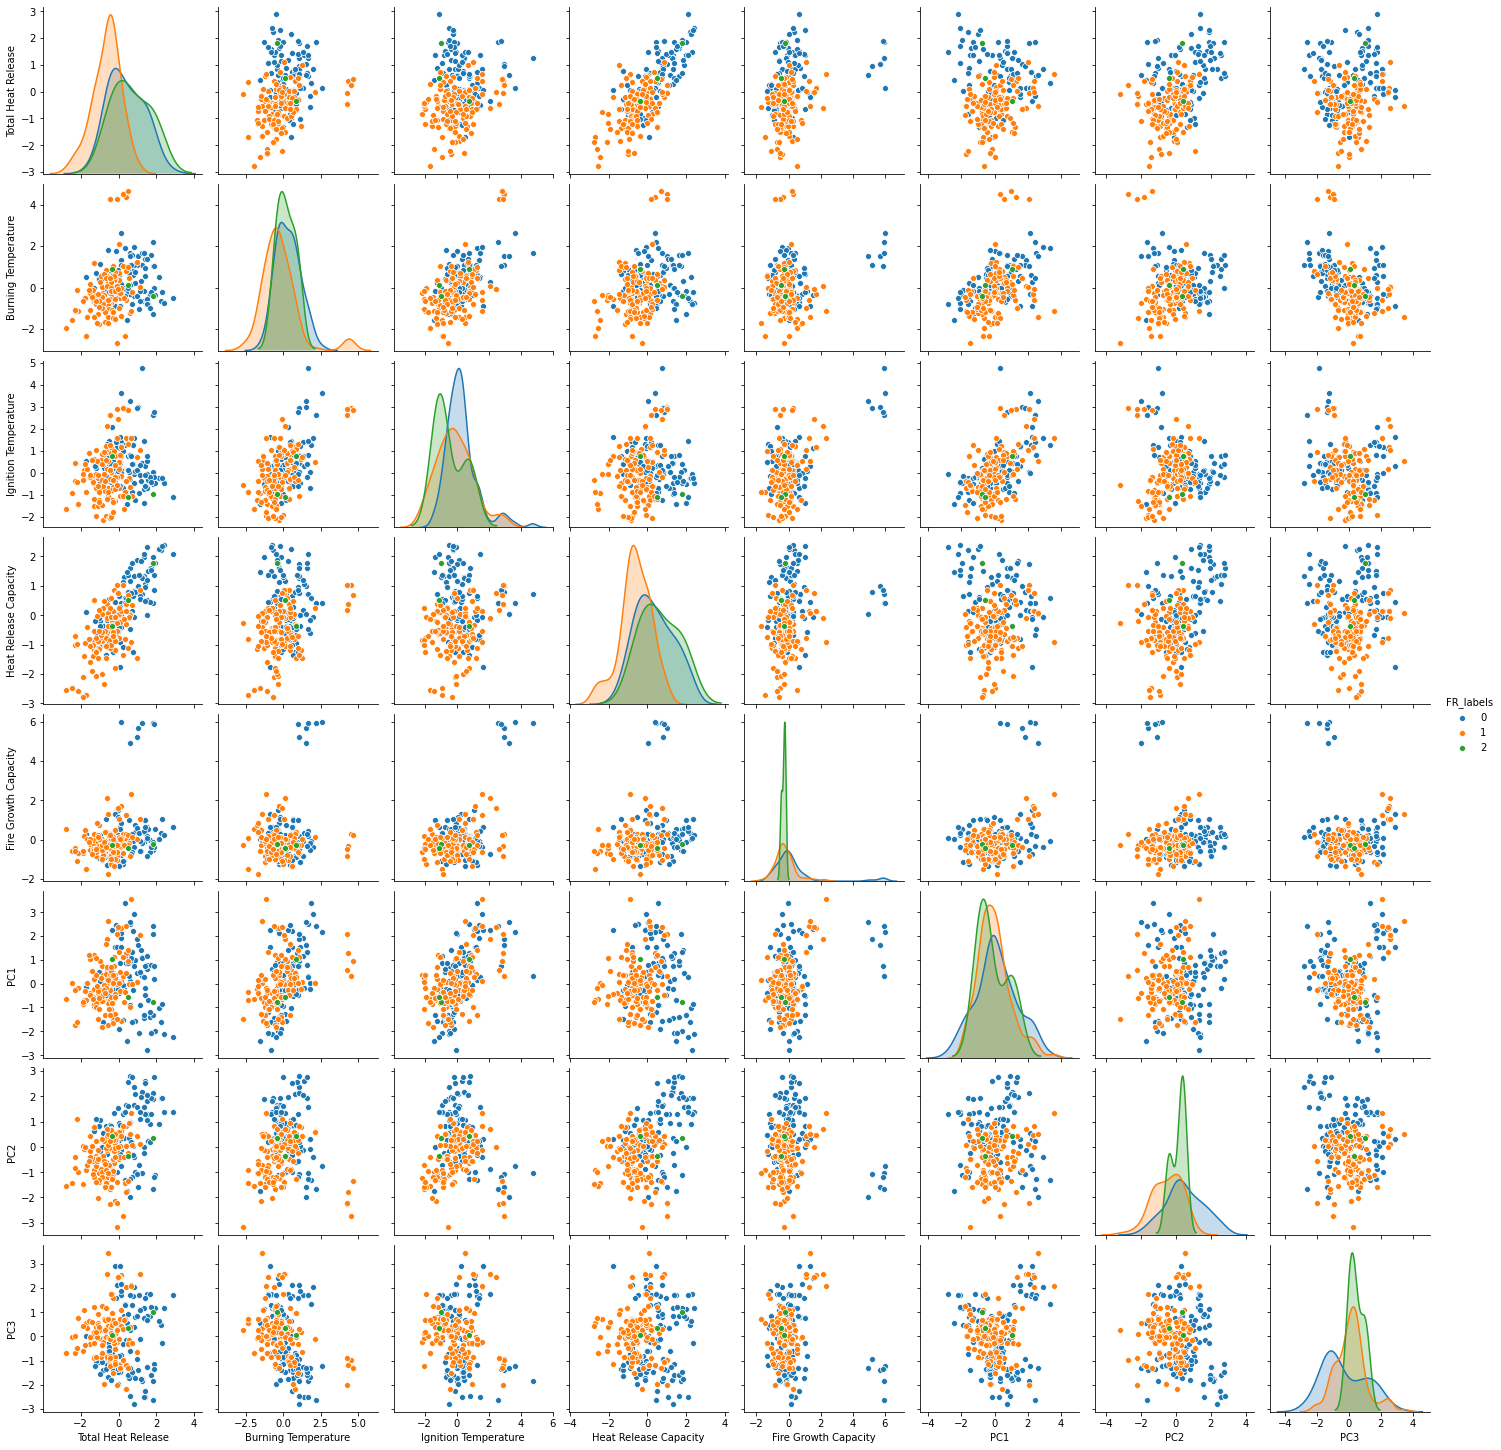

In [29]:
sns.pairplot(final,hue='FR_labels')

##Classifiers

In [30]:
X_ori=origin_feature_matrix.drop(columns='FR_labels').values
y_ori=origin_feature_matrix['FR_labels'].values
X_ori.shape

(41, 8)

#### SVC (Baseline model)

In [31]:
# perform a train-test split. 90% of original data will be used for training
X_svc = final.drop(columns='FR_labels').values
y_svc = final['FR_labels'].values
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size = 0.25)

# define support vector model with rbf kernel
svc = SVC(kernel = 'rbf')

# build up parameter grid and perform GridSearchCV to find the best estimator
alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas
sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

param_grid_svc = {'C': Cs,'gamma': gammas}

svc_search = GridSearchCV(svc, param_grid_svc, cv = 5)
svc_search.fit(X_train_svc,y_train_svc)

# resulting predictions
predict_svc = svc_search.best_estimator_.predict(X_test_svc)
full_predict_svc = svc_search.best_estimator_.predict(X_svc)
origin_predict_svc = svc_search.best_estimator_.predict(X_ori)
# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_svc, predict_svc)))
print('Precision for validation set: {}'.format(precision_score(y_test_svc, predict_svc, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_svc, predict_svc, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_svc, full_predict_svc)))
print('Precision for full dataset: {}'.format(precision_score(y_svc, full_predict_svc, average='macro')))
print('Recall for full dataset: {}'.format(recall_score(y_svc, full_predict_svc, average='macro')))

# print out the accuracy, precison and recall score for the prediction on original dataset (before data generation)
print('Accuracy for original dataset: {}'.format(accuracy_score(y_ori, origin_predict_svc)))
print('Precision for original dataset: {}'.format(precision_score(y_ori, origin_predict_svc, average='macro')))
print('Recall for original dataset: {}'.format(recall_score(y_ori, origin_predict_svc, average='macro')))

Accuracy for validation set: 0.7868852459016393
Precision for validation set: 0.7981283422459893
Recall for validation set: 0.7511261261261262

Accuracy for full dataset: 0.9377593360995851
Precision for full dataset: 0.959494927998865
Recall for full dataset: 0.9581920903954803
Accuracy for original dataset: 0.9024390243902439
Precision for original dataset: 0.9393939393939394
Recall for original dataset: 0.9333333333333332


####Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

X_DT = final.drop(columns='FR_labels').values
y_DT = final['FR_labels'].values
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size = 0.25)

# Create dtree instance
dtree = DecisionTreeClassifier()

# Create parameter grid - currently just max depth
max_depths = [2,3,5,10,15,20, 100]
criterions = ['gini', 'entropy']
param_grid_dtree = {'max_depth': max_depths, 'criterion': criterions}
print(X_DT.shape)
print(y_DT.shape)


(241, 8)
(241,)


In [33]:
# GridSearch Hyperparameter Tuning
DT_search = GridSearchCV(dtree, param_grid_dtree, cv=5)
DT_search.fit(X_train_DT, y_train_DT)

# Predict both the testing set and the full data set
dtree_prediction = DT_search.best_estimator_.predict(X_test_DT)
dtree_full_prediction = DT_search.best_estimator_.predict(X_DT)
dtree_origin_prediction = DT_search.best_estimator_.predict(X_ori)


# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_DT, dtree_prediction)))
print('Precision for validation set: {}'.format(precision_score(y_test_DT, dtree_prediction, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_DT, dtree_prediction, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_DT, dtree_full_prediction)))
print('Precision for full dataset: {}'.format(precision_score(y_DT, dtree_full_prediction, average='macro')))
print('Recall for full dataset: {}\n'.format(recall_score(y_DT, dtree_full_prediction, average='macro')))

# print out the accuracy, precison and recall score for the prediction on original dataset (before data generation)
print('Accuracy for original dataset: {}'.format(accuracy_score(y_ori, dtree_origin_prediction)))
print('Precision for original dataset: {}'.format(precision_score(y_ori, dtree_origin_prediction, average='macro')))
print('Recall for original dataset: {}'.format(recall_score(y_ori, dtree_origin_prediction, average='macro')))



Accuracy for validation set: 0.7704918032786885
Precision for validation set: 0.5241301907968574
Recall for validation set: 0.5132616487455196

Accuracy for full dataset: 0.8464730290456431
Precision for full dataset: 0.7945893719806763
Recall for full dataset: 0.7885122410546139

Accuracy for original dataset: 0.8292682926829268
Precision for original dataset: 0.8944444444444445
Recall for original dataset: 0.7888888888888889


###Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier


X_RF = final.drop(columns='FR_labels').values
y_RF = final['FR_labels'].values
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_RF, y_RF, test_size = 0.25)

# Instantiate random forest model
ranfor = RandomForestClassifier()

# Create parameter grid 
# We are searching over two hyperparameters for our Random Forest model


n_estimators = [3, 5, 7, 10, 15, 20, 25, 50, 100]
maximum_feats = ['auto', 'log2']
max_depths = [2,3,5,10,15,20, 100]
criterions = ['gini', 'entropy']
param_grid_ranfor = {'n_estimators': n_estimators, 'criterion': criterions, 'max_features': maximum_feats,'max_depth': max_depths}




In [35]:
# GridSearch Hyperparameter Tuning
RF_search = GridSearchCV(ranfor, param_grid_ranfor, cv=5)
RF_search.fit(X_train_RF, y_train_RF)

# Predict both the testing set and the full data set
ranfor_prediction = RF_search.best_estimator_.predict(X_test_RF)
ranfor_full_prediction = RF_search.best_estimator_.predict(X_RF)
ranfor_origin_prediction = RF_search.best_estimator_.predict(X_ori)

# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_RF, ranfor_prediction)))
print('Precision for validation set: {}'.format(precision_score(y_test_RF, ranfor_prediction, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_RF, ranfor_prediction, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_RF, ranfor_full_prediction)))
print('Precision for full dataset: {}'.format(precision_score(y_RF, ranfor_full_prediction, average='macro')))
print('Recall for full dataset: {}\n'.format(recall_score(y_RF, ranfor_full_prediction, average='macro')))

# print out the accuracy, precison and recall score for the prediction on original dataset (before data generation)
print('Accuracy for original dataset: {}'.format(accuracy_score(y_ori, ranfor_origin_prediction)))
print('Precision for original dataset: {}'.format(precision_score(y_ori, ranfor_origin_prediction, average='macro')))
print('Recall for original dataset: {}'.format(recall_score(y_ori, ranfor_origin_prediction, average='macro')))


Accuracy for validation set: 0.6721311475409836
Precision for validation set: 0.6726190476190477
Recall for validation set: 0.671505376344086

Accuracy for full dataset: 0.9128630705394191
Precision for full dataset: 0.9414553267012283
Recall for full dataset: 0.8328154425612052

Accuracy for original dataset: 0.9024390243902439
Precision for original dataset: 0.9324561403508772
Recall for original dataset: 0.837037037037037


###KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

X_KNN = final.drop(columns='FR_labels').values
y_KNN = final['FR_labels'].values
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_KNN, y_KNN, test_size = 0.25)

KNN = KNeighborsClassifier()
# neighbors = np.array([2,4,6,8,10,12,15,18,20,15])
neighbors = np.array([2,3])
KNN_param_grid = {'n_neighbors': neighbors}

In [37]:
# Hyperparameter tunning
KNN_search = GridSearchCV(KNN, KNN_param_grid, cv=5)
KNN_search.fit(X_train_KNN, y_train_KNN)

# resulting predictions
predict_KNN = KNN_search.best_estimator_.predict(X_test_KNN)
full_predict_KNN = KNN_search.best_estimator_.predict(X_KNN)
origin_predict_KNN = KNN_search.best_estimator_.predict(X_ori)

# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_KNN, predict_KNN)))
print('Precision for validation set: {}'.format(precision_score(y_test_KNN, predict_KNN, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_KNN, predict_KNN, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_KNN, full_predict_KNN)))
print('Precision for full dataset: {}'.format(precision_score(y_KNN, full_predict_KNN, average='macro')))
print('Recall for full dataset: {}\n'.format(recall_score(y_KNN, full_predict_KNN, average='macro')))

# print out the accuracy, precison and recall score for the prediction on original dataset (before data generation)
print('Accuracy for original dataset: {}'.format(accuracy_score(y_ori, origin_predict_KNN)))
print('Precision for original dataset: {}'.format(precision_score(y_ori, origin_predict_KNN, average='macro')))
print('Recall for original dataset: {}'.format(recall_score(y_ori, origin_predict_KNN, average='macro')))

Accuracy for validation set: 0.7704918032786885
Precision for validation set: 0.5132902298850575
Recall for validation set: 0.5306513409961685

Accuracy for full dataset: 0.8755186721991701
Precision for full dataset: 0.5839307048984468
Recall for full dataset: 0.5911487758945386

Accuracy for original dataset: 0.8292682926829268
Precision for original dataset: 0.5531746031746031
Recall for original dataset: 0.5981481481481481
